In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import os 
import random
from tqdm import tqdm 

from VariationalModel import *

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from typing import List

In [3]:
dataDirectory = 'Dataset'


trainDataset = torchvision.datasets.MNIST(dataDirectory, train=True, download=True)
testDataset  = torchvision.datasets.MNIST(dataDirectory, train=False, download=True)

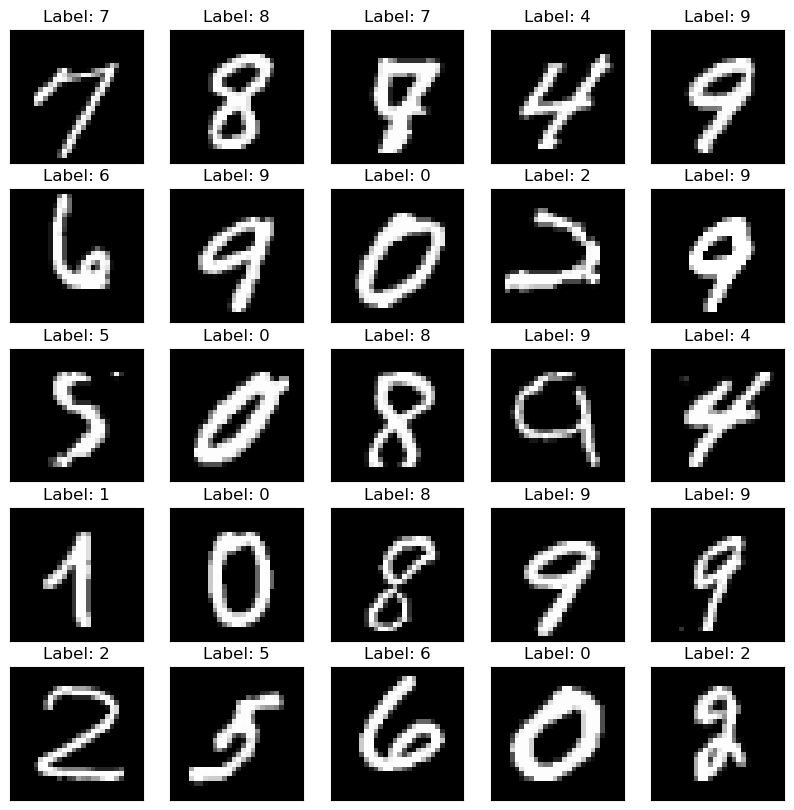

In [4]:
fig, axs = plt.subplots(5, 5, figsize = (10, 10))

for ax in axs.flatten():
   img, label = random.choice(trainDataset)
   ax.imshow(np.array(img), cmap = 'gist_gray')
   ax.set_title(f'Label: {label}')
   ax.set_xticks([])
   ax.set_yticks([])

In [5]:
#Transforms in pytorch tensors
trainTransform = transforms.Compose([transforms.ToTensor(),])
testTransform = transforms.Compose([transforms.ToTensor(),])

trainDataset.transform = trainTransform
testDataset.transform = testTransform

In [6]:
#Define the Dataloader
trainDataloader = DataLoader(trainDataset, batch_size=256, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=256, shuffle=False)

batch_data, batch_labels = next(iter(trainDataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(testDataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


In [8]:
model = VariationalAutoEncoder(latentDim = 10, hiddenDim=[200, 100, 100, 100])

In [12]:
loss_fn = torch.nn.MSELoss()

lr = 5e-4
parameToOptimize = [
   {'params': model.parameters()}
]

optim = torch.optim.Adam(parameToOptimize, lr = lr)
if torch.backends.mps.is_available():
   device = torch.device("mps")
elif torch.cuda.is_available():
   device = torch.device("cuda")
else:
   device = torch.device("cpu")

print(f'Selected device: {device}')

model.to(device)

Selected device: mps


VariationalAutoEncoder(
  (Encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=200, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=200, out_features=100, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
  )
  (EncoderMu): Linear(in_features=100, out_features=10, bias=True)
  (EncoderSigma): Linear(in_features=100, out_features=10, bias=True)
  (Decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=100, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
  

In [13]:
def Training(model):
   model.train()
   losses = []

   for imageBatch, _ in tqdm(trainDataloader):

      imageBatch = imageBatch.to(device)
      results, z, mean, std = model(imageBatch)

      flat_targets = imageBatch.view(imageBatch.size(0), -1)
      loss = loss_fn(results, flat_targets)

      optim.zero_grad()
      loss.backward()
      optim.step()

      losses.append(loss.detach().cpu().numpy())

   losses = np.mean(losses)

   return losses 

EPOCH 1/10


100%|██████████| 235/235 [00:09<00:00, 24.21it/s]


TRAIN - EPOCH 1/10 - loss: 0.026609882712364197


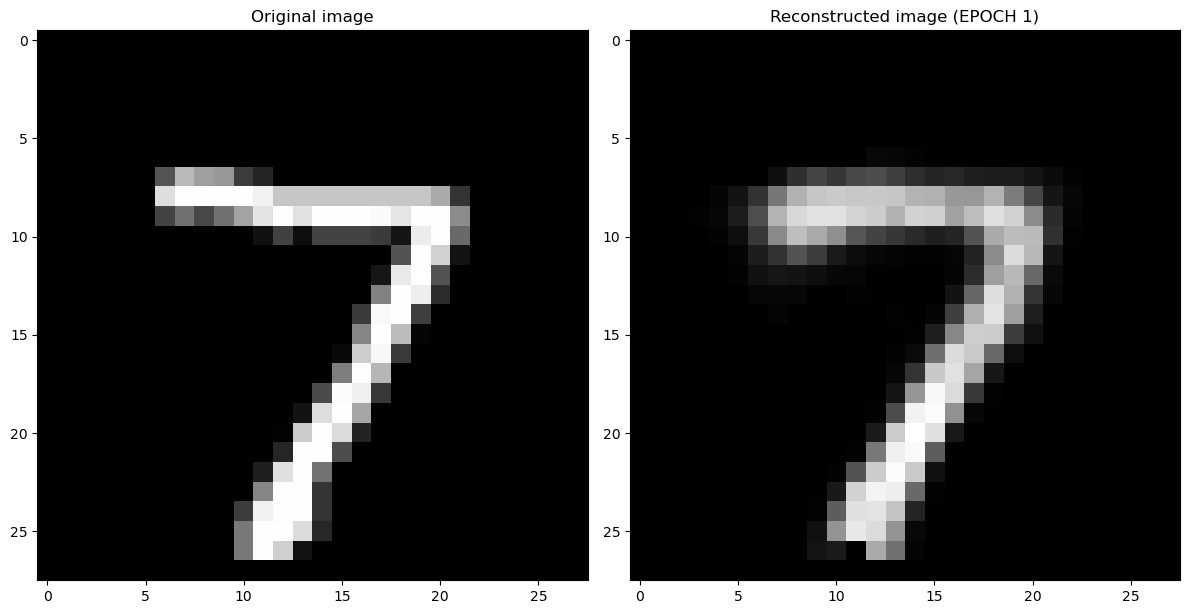

EPOCH 2/10


100%|██████████| 235/235 [00:05<00:00, 46.67it/s]


TRAIN - EPOCH 2/10 - loss: 0.025676313787698746


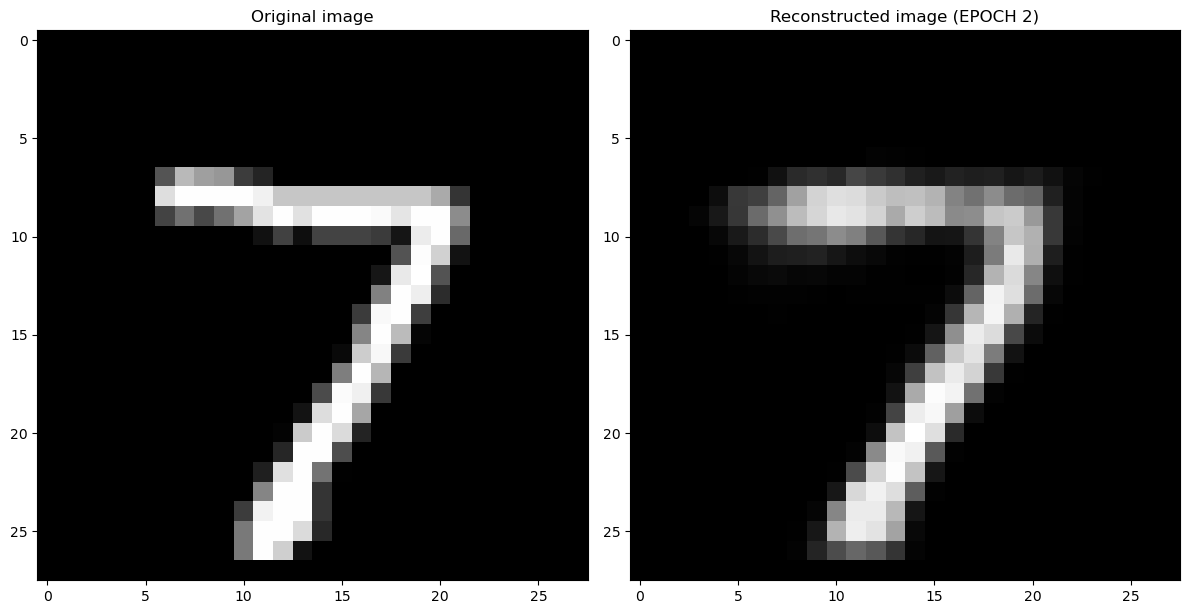

EPOCH 3/10


100%|██████████| 235/235 [00:05<00:00, 45.52it/s]


TRAIN - EPOCH 3/10 - loss: 0.025096535682678223


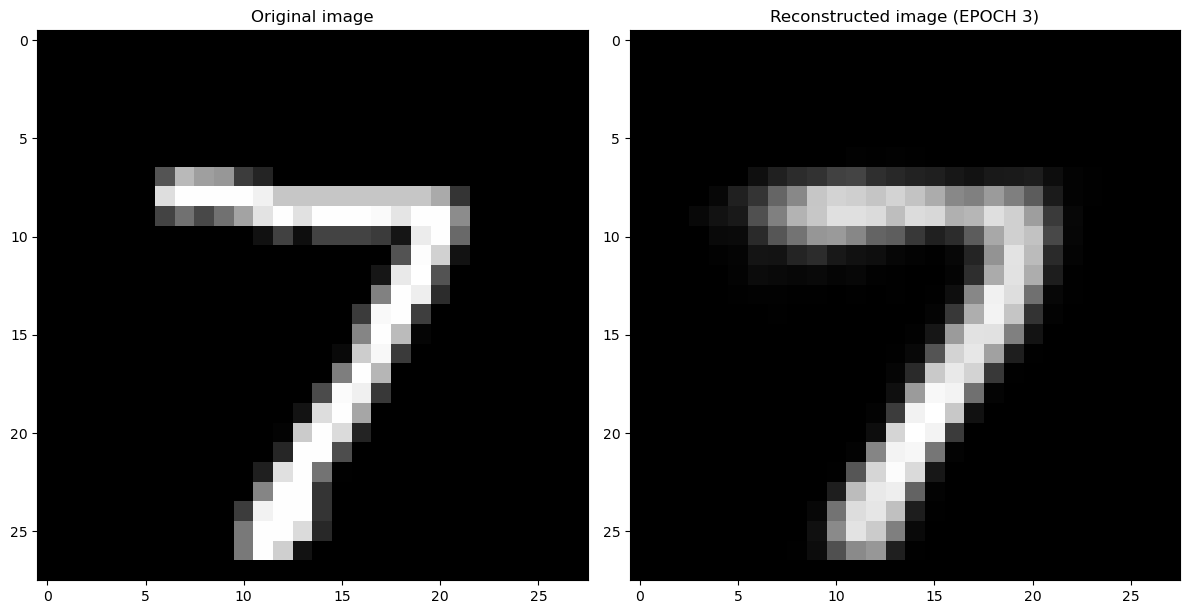

EPOCH 4/10


100%|██████████| 235/235 [00:05<00:00, 46.55it/s]


TRAIN - EPOCH 4/10 - loss: 0.024603547528386116


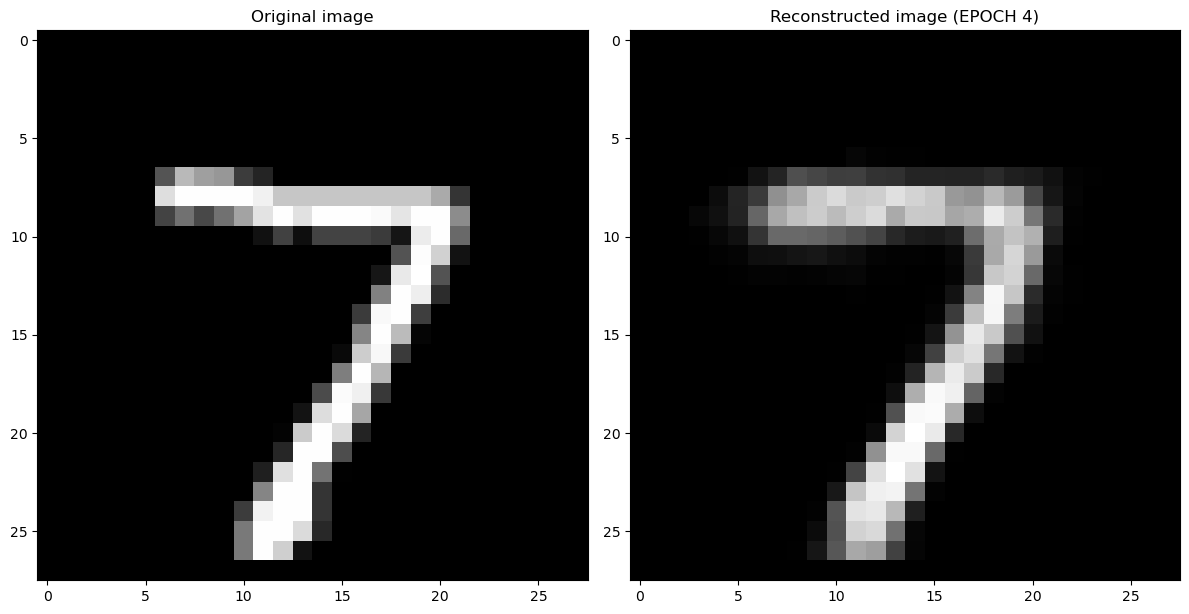

EPOCH 5/10


100%|██████████| 235/235 [00:04<00:00, 47.54it/s]


TRAIN - EPOCH 5/10 - loss: 0.02411908097565174


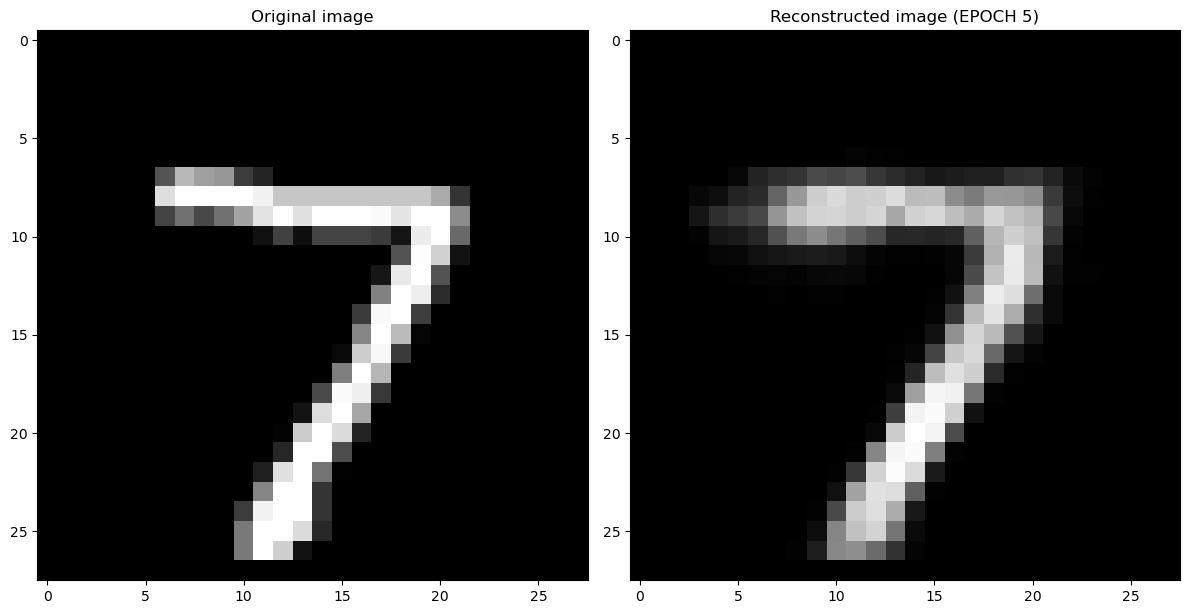

EPOCH 6/10


100%|██████████| 235/235 [00:04<00:00, 47.74it/s]


TRAIN - EPOCH 6/10 - loss: 0.023717079311609268


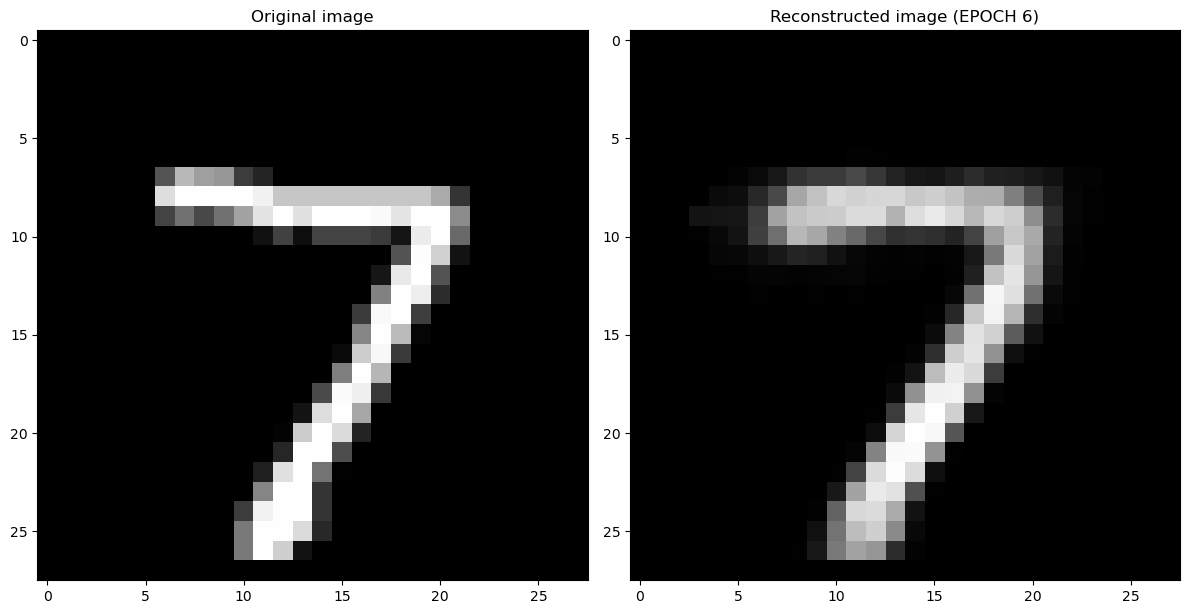

EPOCH 7/10


100%|██████████| 235/235 [00:04<00:00, 47.93it/s]


TRAIN - EPOCH 7/10 - loss: 0.023359108716249466


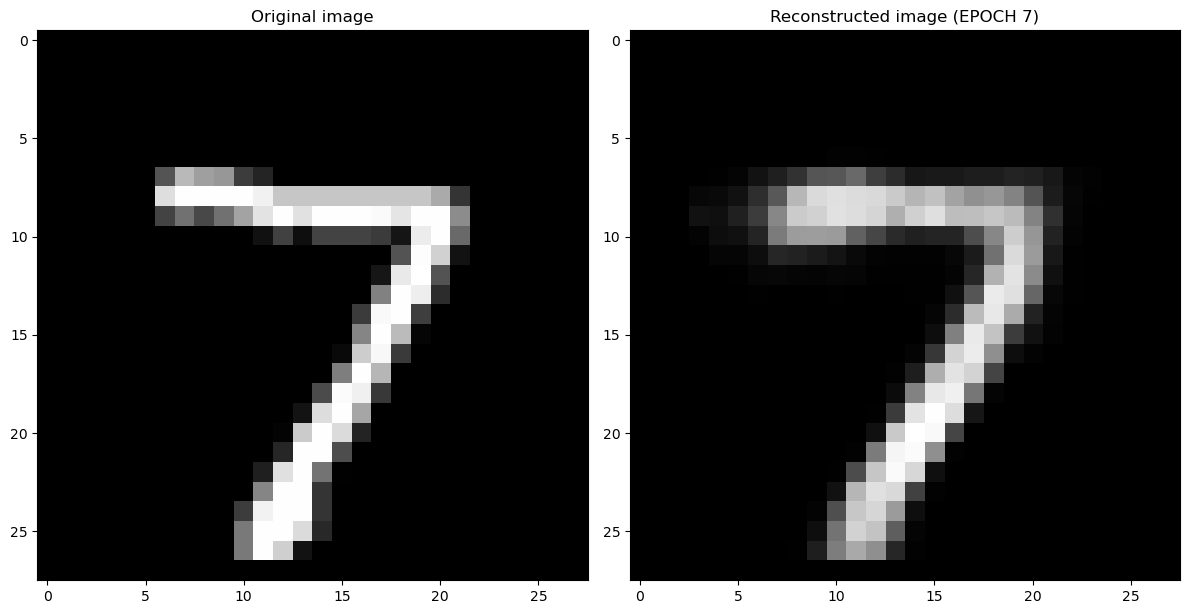

EPOCH 8/10


100%|██████████| 235/235 [00:05<00:00, 46.92it/s]


TRAIN - EPOCH 8/10 - loss: 0.023028232157230377


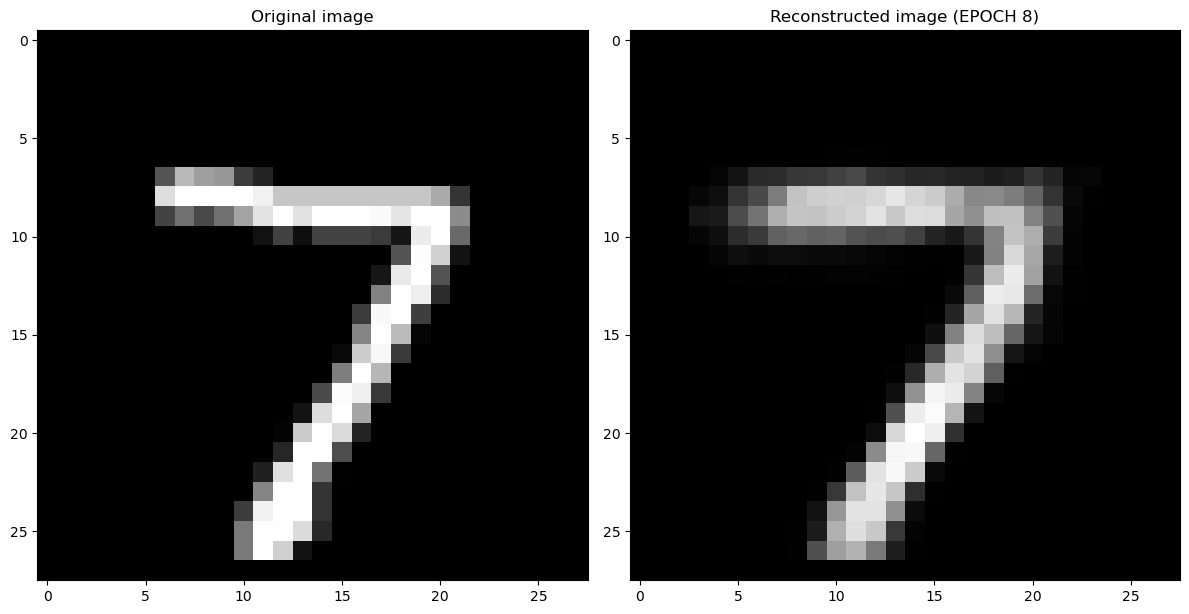

EPOCH 9/10


100%|██████████| 235/235 [00:04<00:00, 47.00it/s]


TRAIN - EPOCH 9/10 - loss: 0.022714147344231606


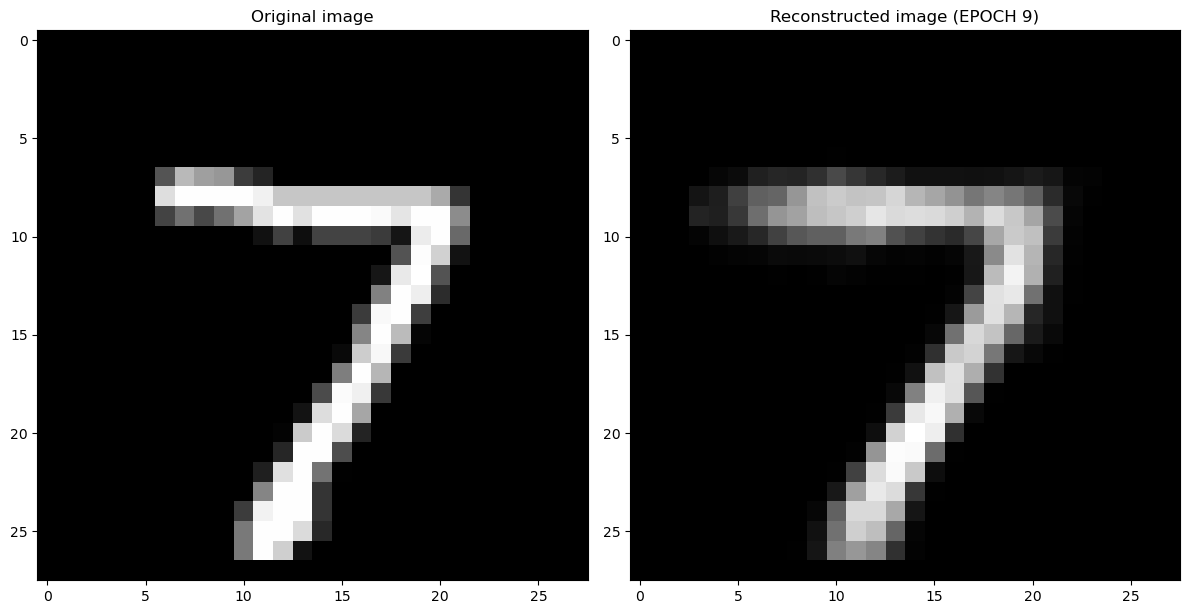

EPOCH 10/10


100%|██████████| 235/235 [00:04<00:00, 48.11it/s]


TRAIN - EPOCH 10/10 - loss: 0.022404847666621208


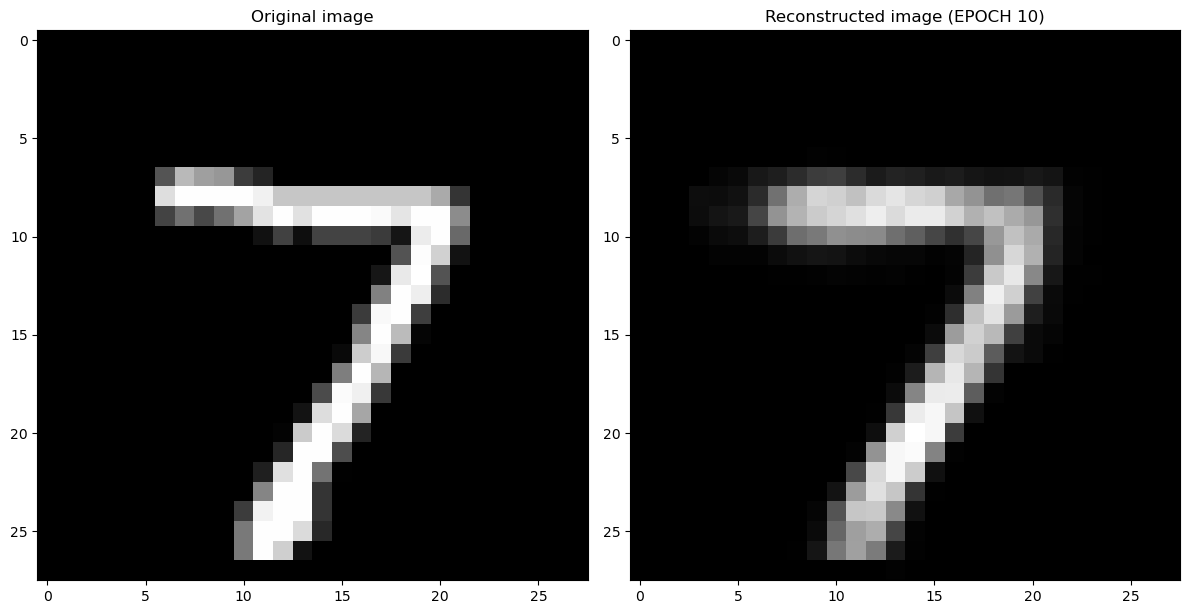

In [14]:
### Training cycle

num_epochs = 10
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss = Training(model)
    print(f'TRAIN - EPOCH {epoch+1}/{num_epochs} - loss: {train_loss}')

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = testDataset[0][0].unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        rec_img  = model(img)
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img[0].cpu().squeeze().numpy().reshape(28, 28), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    plt.show()
    plt.close()
